In [ ]:
# Import packages and libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns


In [ ]:
#Import CIFAR-10 dataset from Keras datasets module
from keras.datasets import cifar10

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

170498071/170498071 [==============================] - 21s 0us/step


In [ ]:
x_val.shape

(10000, 32, 32, 3)

In [ ]:
x_train.shape


(40000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
#Normalize and convert images to float and convert labels to integers
x_train = (x_train / 255.).astype(np.float32)
y_train = y_train.astype(np.int64)
x_val = (x_val / 255.).astype(np.float32)
y_val = y_val.astype(np.int64)
x_test = (x_test / 255.).astype(np.float32)

In [ ]:
# Resize images
def resize_images(images):
    return tf.image.resize(images, (75, 75))

x_train_resized = resize_images(x_train)
x_test_resized = resize_images(x_test)
x_val_resized = resize_images(x_val)

In [ ]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_val_cat = tf.keras.utils.to_categorical(y_val, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator (rescaling done previously)
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# No augmentation (rescaling done previously)
test_datagen = ImageDataGenerator()

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(x_train_resized,
                                     y_train_cat,
                                     batch_size=32,
                                     shuffle=True)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow(x_val_resized,
                                         y_val_cat,
                                         batch_size=32,
                                         shuffle=False)

print("Found", len(x_train), "images belonging to", len(np.unique(y_train)), "classes.")
print("Found", len(x_val), "images belonging to", len(np.unique(y_val)), "classes.")

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-05 13:22:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  21.3MB/s    in 5.1s    

2024-06-05 13:22:08 (16.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(weights=None, include_top=False, input_shape=(75, 75, 3))

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu', name='Dense_Layer_1')(x)

# Add a final softmax layer for classification with 10 classes
x = tf.keras.layers.Dense(10, activation='softmax', name='Output')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

In [ ]:
# Set the training parameters
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_steps=len(validation_generator),
    verbose=2
)

Epoch 1/20
1250/1250 - 91s - loss: 1.1718 - accuracy: 0.5930 - val_loss: 1.0667 - val_accuracy: 0.6338 - 91s/epoch - 73ms/step
Epoch 2/20
1250/1250 - 91s - loss: 1.1675 - accuracy: 0.5954 - val_loss: 1.0630 - val_accuracy: 0.6358 - 91s/epoch - 72ms/step
Epoch 3/20
1250/1250 - 90s - loss: 1.1639 - accuracy: 0.5993 - val_loss: 1.0747 - val_accuracy: 0.6311 - 90s/epoch - 72ms/step
Epoch 4/20
1250/1250 - 89s - loss: 1.1607 - accuracy: 0.5972 - val_loss: 1.0612 - val_accuracy: 0.6342 - 89s/epoch - 71ms/step
Epoch 5/20
1250/1250 - 90s - loss: 1.1592 - accuracy: 0.6000 - val_loss: 1.0589 - val_accuracy: 0.6374 - 90s/epoch - 72ms/step
Epoch 6/20
1250/1250 - 111s - loss: 1.1579 - accuracy: 0.5979 - val_loss: 1.0664 - val_accuracy: 0.6356 - 111s/epoch - 89ms/step
Epoch 7/20
1250/1250 - 92s - loss: 1.1528 - accuracy: 0.6028 - val_loss: 1.0565 - val_accuracy: 0.6442 - 92s/epoch - 73ms/step
Epoch 8/20
1250/1250 - 90s - loss: 1.1525 - accuracy: 0.6009 - val_loss: 1.0749 - val_accuracy: 0.6392 - 90s/

In [ ]:
#Evaluation on the test dataset
test_loss, test_acc = model.evaluate(x_test_resized, y_test_cat, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.6388000249862671


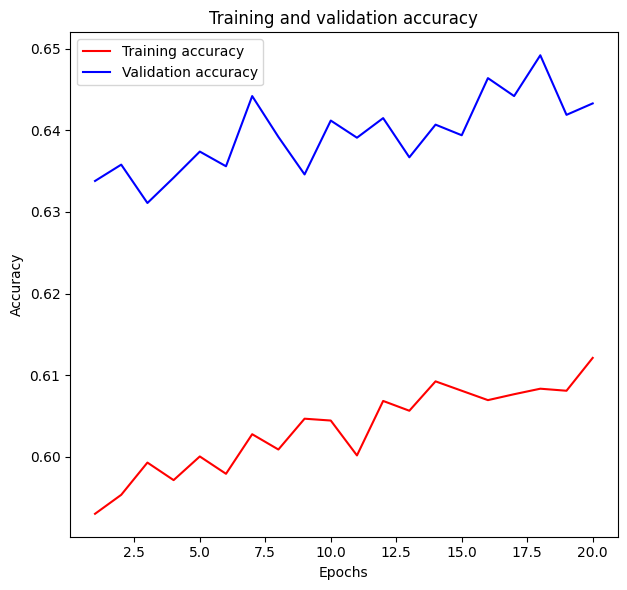

In [ ]:
#Plot validation and training accuracy over epochs
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test data
y_pred = model.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

313/313 [==============================] - 6s 13ms/step
Precision: 0.6447311424428018
Recall: 0.6388
F1-score: 0.6383507639356824


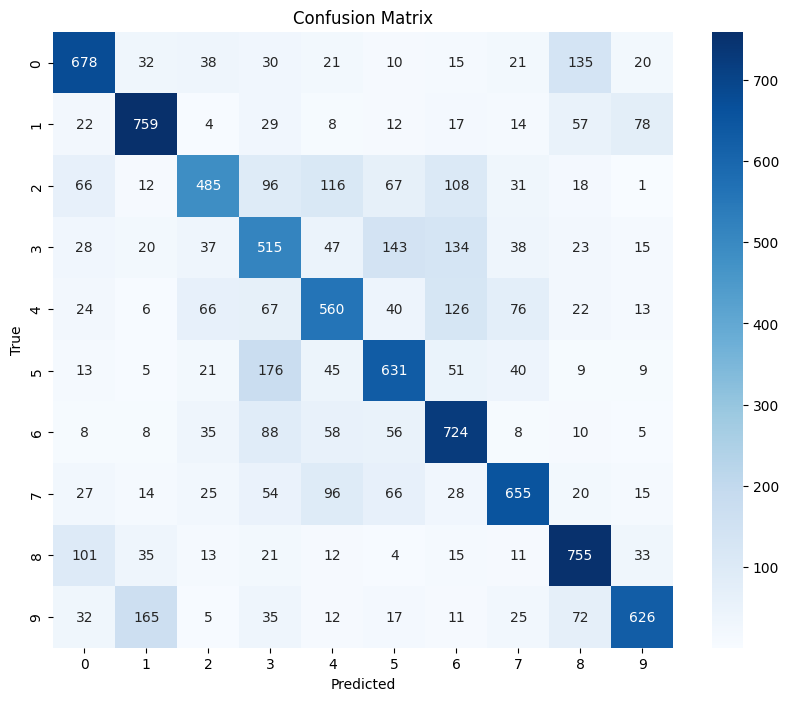

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#VGG
# Initialize the base VGG16 model
pre_trained_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze the weights
for layer in pre_trained_model_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Add a fully connected layer
x_vgg = tf.keras.layers.Flatten()(pre_trained_model_vgg.output)
x_vgg = tf.keras.layers.Dense(1024, activation='relu', name='Dense_Layer_1_VGG')(x_vgg)
x_vgg = tf.keras.layers.Dense(10, activation='softmax', name='Output_VGG')(x_vgg)

# Create the model
model_vgg = Model(pre_trained_model_vgg.input, x_vgg)

In [ ]:
# Compile the model
model_vgg.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Train the model
history_vgg = model_vgg.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_steps=len(validation_generator),
    verbose=2
)

Epoch 1/20
1250/1250 - 131s - loss: 1.5102 - accuracy: 0.4769 - val_loss: 1.1605 - val_accuracy: 0.6128 - 131s/epoch - 105ms/step
Epoch 2/20
1250/1250 - 93s - loss: 1.3106 - accuracy: 0.5419 - val_loss: 1.1149 - val_accuracy: 0.6201 - 93s/epoch - 75ms/step
Epoch 3/20
1250/1250 - 92s - loss: 1.2502 - accuracy: 0.5649 - val_loss: 1.0404 - val_accuracy: 0.6417 - 92s/epoch - 74ms/step
Epoch 4/20
1250/1250 - 89s - loss: 1.2107 - accuracy: 0.5779 - val_loss: 1.0521 - val_accuracy: 0.6361 - 89s/epoch - 71ms/step
Epoch 5/20
1250/1250 - 89s - loss: 1.1917 - accuracy: 0.5846 - val_loss: 0.9579 - val_accuracy: 0.6726 - 89s/epoch - 71ms/step
Epoch 6/20
1250/1250 - 90s - loss: 1.1723 - accuracy: 0.5912 - val_loss: 0.9870 - val_accuracy: 0.6639 - 90s/epoch - 72ms/step
Epoch 7/20
1250/1250 - 89s - loss: 1.1502 - accuracy: 0.6010 - val_loss: 0.9595 - val_accuracy: 0.6715 - 89s/epoch - 71ms/step
Epoch 8/20
1250/1250 - 89s - loss: 1.1372 - accuracy: 0.6022 - val_loss: 0.9720 - val_accuracy: 0.6633 - 89s

In [ ]:
#Evaluation on the test dataset
test_loss, test_acc = model_vgg.evaluate(x_test_resized, y_test_cat, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.6924999952316284


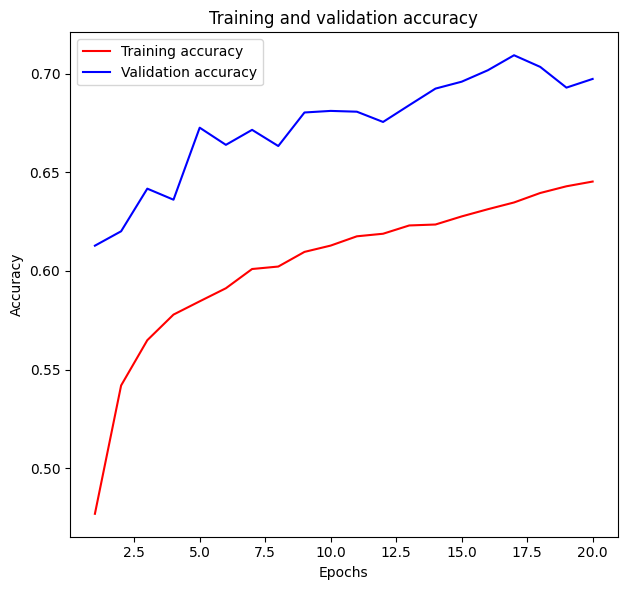

In [ ]:
#Plot validation and training accuracy over epochs
# Extract metrics
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test data
y_pred = model_vgg.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

313/313 [==============================] - 7s 20ms/step
Precision: 0.7034669840639807
Recall: 0.6925
F1-score: 0.6908431639320154


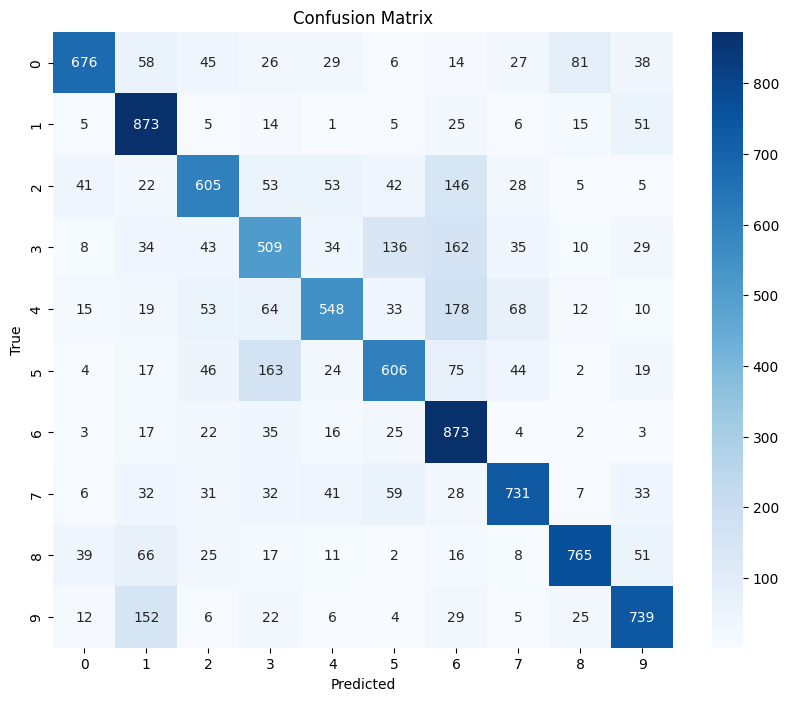

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()